## A. Creating Spark Session and Loading the Data

## Step 01: Import Spark Session and initialize Spark

Firstly, I will create a sparkSession object with 4 local cores by calling "local[4]". 

Secndly, I will give the application a name of "Big Data Rain Prediction" using "appName()". 

In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

sc = SparkContext(master="local[4]", appName="Big Data Rain Prediction")
spark = SparkSession(sparkContext=sc)
print (sc)

<SparkContext master=local[4] appName=Big Data Rain Prediction>


## Step 02: Load the dataset and print the schema and total number of entries

I will use sparkSession to read a csv file, display the headers and then count the number of entires.

In [2]:
# read the csv file
df = spark.read.csv('weatherAUS.csv',  header=True, inferSchema=True)
print("Total number of entries:", df.count(), "records")

Total number of entries: 142193 records


Here the schema of the data frame can be examined.

In [ ]:
print("The original data table schema is displayed as below.")
print("")
df.printSchema()

## B. Data Cleaning and Processing

## Step 03: Delete columns from the dataset

Before processing the data, I will delete unnecessary columns for efficiency purpose using Spark data frame's "drop" function.

In [3]:
df_trimmed = df.drop("Date","Location","Evaporation","Sunshine","Cloud9am","Cloud3pm","Temp9am", "Temp3pm")
print("The data table schema after removing columns is displayed as below.")
print("")
df_trimmed.printSchema()

The data table schema after removing columns is displayed as below.

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## The remaining columns are listed as below.

MinTemp,
MaxTemp,

Rainfall,
,WindGustDir,
WindGustSpeed,

WindDir9am,
WindDir3pm,

WindSpeed9am,
WindSpeed3pm,

Humidity9am,
Humidity3pm,

Pressure9am,
Pressure3pm,

RainToday,
RainTomorrow

## Step 04 Print the number of missing data in each column.

## Replace null/empty values with "NA".

Before resolving the "none" values, in order not to resolve all empty values before processing, I will should replace the empty values with "NA" so that all "none" values are presented as "NA". 

In [4]:
df_trimmed = df_trimmed.na.fill("NA")

Import the functions library

In [5]:
from pyspark.sql import functions as F

## Count all "NA" values.

This function loops over each column and then count the occurence of the "NA" value.

In [6]:
def count_na(df, col_name_list):
    print()
    print("The number of empty values in each column is listed as below.")
    print("--------------------------------------------------------------")
    total = 0
    for col_name in col_name_list:
        count = df.filter(df[col_name]=="NA").count()
        total += count
        print(col_name + ":", count)
    print("--------------------------------------------------------------")
    print("Empty Values in Total: ", total)

## Display the count of empty Values.
Assign the list containing the column names to the function declared above.

In [7]:
col_name_list = ["MinTemp", "MaxTemp", "Rainfall", "WindGustDir", "WindGustSpeed", "WindDir9am", "WindDir3pm", "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","RainToday","RainTomorrow"]
count_na(df_trimmed, col_name_list)


The number of empty values in each column is listed as below.
--------------------------------------------------------------
MinTemp: 637
MaxTemp: 322
Rainfall: 1406
WindGustDir: 9330
WindGustSpeed: 9270
WindDir9am: 10013
WindDir3pm: 3778
WindSpeed9am: 1348
WindSpeed3pm: 2630
Humidity9am: 1774
Humidity3pm: 3610
Pressure9am: 14014
Pressure3pm: 13981
RainToday: 1406
RainTomorrow: 0
--------------------------------------------------------------
Empty Values in Total:  73519


## Record the count of empty values for double checking later after they are resolved.

The following information can be referred from the data above.

Empty Values in Non-Numeric Columns: 24527 , 

Empty Values in Numeric Columns: 48992

Such information will be used later to test the answer.

## Step 05: Fill the missing data with average value and maximum occurrence value.

## Examine the numeric and non-numeric columns manually by printing the top 5 rows.

The columns with numeric values are listed as below.

MinTemp,
MaxTemp,
Rainfall,
WindGustSpeed
WindSpeed9am,
WindSpeed3pm,
Humidity9am,
Humidity3pm,
Pressure9am,
Pressure3pm,




The columns with non-numeric values are listed as below.

WindGustDir
WindDir9am,
WindDir3pm
RainToday,
RainTomorrow

## Testing the function to extract the average value from a numeric column.

Before defining the function, a small test is conducted to ensure the right data type.

In [8]:
result = df_trimmed.filter(df["MinTemp"]!="NA").agg({"MinTemp": "avg"}).collect()[0]["avg(MinTemp)"]
print("The result of the testing feature that extracts the average value is ",result)
print("The data type is ", type(result))

The result of the testing feature that extracts the average value is  12.186399728729311
The data type is  <class 'float'>


## Extract the average value from numeric columns.
## Round the average value to 1 digit as the original numeric values are all in 1 digit.

Define a function that calculates the average numeric value in each column, where the value is not "NA"

In [9]:
def replace_with_average(df, col_name_list):
    new_df = df  # instantiate the result with the initial data frame
    for col_name in col_name_list:
        avg_col_name = "avg(" + col_name + ")"
        avg = new_df.filter(new_df[col_name]!="NA").agg({col_name: "avg"}).collect()[0][avg_col_name] # find the average value
        avg = round(avg,1)
        avg_str = str(avg)
        new_df = new_df.replace("NA", avg_str, col_name)
    return new_df

Assign a list containing the numeric column names into the function declared above.

In [10]:
num_col_list = ["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm"]
df_05 = replace_with_average(df_trimmed, num_col_list)

## Check the remaining count of "NA" values after resolving numeric columns.
This function takes in a data frame and a list of numeric column names. It returns the count of the "NA" values.
The remaining count should be equal to the "NA" values within the non-numeric columns.

In [11]:
def check_na_count(df, num_col_list):
    count = 0
    for col_name in col_name_list:
        result = df.filter(df[col_name] =="NA").count()
        count+= result
    return count

## Working as expteced.
Assign the processed data frame and numeric columns to the function declared above.

In [12]:
count = check_na_count(df_05, num_col_list)
print("Number of Empty Records After resolving the Numeric Columns:", count)

Number of Empty Records After resolving the Numeric Columns: 24527


As this number corresponds with the empty values in non-numeric columns, all numeric empty values have been replaced.

## Then, for non-numeric columns, I will find the item most popular in the non-numeric list.

In [13]:
non_numeric_list = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]

df_non_numeric = df_05.select("WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow")
df_non_numeric.show(truncate = False)

+-----------+----------+----------+---------+------------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|
+-----------+----------+----------+---------+------------+
|W          |W         |WNW       |No       |No          |
|WNW        |NNW       |WSW       |No       |No          |
|WSW        |W         |WSW       |No       |No          |
|NE         |SE        |E         |No       |No          |
|W          |ENE       |NW        |No       |No          |
|WNW        |W         |W         |No       |No          |
|W          |SW        |W         |No       |No          |
|W          |SSE       |W         |No       |No          |
|NNW        |SE        |NW        |No       |Yes         |
|W          |S         |SSE       |Yes      |No          |
|N          |SSE       |ESE       |No       |Yes         |
|NNE        |NE        |ENE       |Yes      |Yes         |
|W          |NNW       |NNW       |Yes      |Yes         |
|SW         |W         |SSW       |Yes      |No         

In [14]:
def get_most_occurence(df, col_name_list):
    non_numeric_words = []
    for col_name in col_name_list:
        temp_df = df.groupBy(col_name).count()
        temp_df.registerTempTable("df_table")
        top_count = spark.sql("SELECT MAX(count) as maxval FROM df_table").first().asDict()['maxval']
        most_popular_word = temp_df.filter(temp_df["count"]>=top_count).collect()[0][col_name]
        non_numeric_words.append(most_popular_word)
    return non_numeric_words

The most freqeuntly occurred words in the non-numeric columns are listed as below.

## The most occurred words within non-numeric columns, 

## "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow", are

## "W", "N", "SE", "No" and "No".

In [15]:
word_list = get_most_occurence(df_non_numeric, non_numeric_list)
word_list

['W', 'N', 'SE', 'No', 'No']

## Replace the "NA" values within the non-numeric columns with the most occurred words.

In [16]:
def replace_non_numeric(df, col_name_list, word_list):
    global new_df
    new_df= df
    for col_name in col_name_list:
        index = col_name_list.index(col_name)
        new_df = new_df.replace("NA", word_list[index], col_name)
    return new_df
df_05_02 = replace_non_numeric(df_05, non_numeric_list, word_list)

## Double check that all "NA" values in the non-numeric columns have been removed.

In [17]:
df_05_02.filter((df_05_02["WindGustDir"]=="NA")|(df_05_02["WindDir9am"]=="NA")| (df_05_02["WindDir3pm"]=="NA")|(df_05_02["RainToday"]=="NA") ).show(truncate =False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



It is clear that all "Na" values have been removed.

## Step 06: Data transformation

## Cast the data type of numeric columns from String to double

This function takes in a data frame and a list of strings representing the column name.

It loops over each column and converts the data type to double.

In [18]:
from pyspark.sql.types import DoubleType

def str_to_double(df, col_name_list):
    new_df = df
    for col_name in col_name_list:
        new_df = new_df.withColumn(col_name, new_df[col_name].cast(DoubleType()))
    return new_df


df_06_numeric = str_to_double(df_05_02, num_col_list)

## Check the data type after casting

This function takes in a data frame and a list of string representing column names.

It displays the data type of each column.

In [19]:
def check_numeric_casting(df, col_name_list):
    print()
    print("The data type of each numeric column is listed as below.")
    for col_name in col_name_list:
        test = df.collect()[0][col_name]
        print(col_name, ": ", type(test))
        
check_numeric_casting(df_06_numeric, num_col_list)


The data type of each numeric column is listed as below.
MinTemp :  <class 'float'>
MaxTemp :  <class 'float'>
Rainfall :  <class 'float'>
WindGustSpeed :  <class 'float'>
WindSpeed9am :  <class 'float'>
WindSpeed3pm :  <class 'float'>
Humidity9am :  <class 'float'>
Humidity3pm :  <class 'float'>
Pressure9am :  <class 'float'>
Pressure3pm :  <class 'float'>


## Cast the non-numeric columns to from String to index using StringIndexer

Firstly, import the library.

In [20]:
from pyspark.ml.feature import StringIndexer

This function takes in a data frame and a list of string representing column names.

It displays the data type of each column.

In [21]:
def str_to_index(df, col_name_list):
    new_df = df
    for col_name in col_name_list:
        index_col_name = col_name + "Index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col_name)
        new_df = indexer.fit(new_df).transform(new_df)
        new_df =new_df.drop(new_df[col_name])
    return new_df

## Display the data frame after indexing.

In [22]:
df_06_done = str_to_index(df_06_numeric, non_numeric_list)
df_06_done.show(truncate = False)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDirIndex|WindDir9amIndex|WindDir3pmIndex|RainTodayIndex|RainTomorrowIndex|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+---------------+---------------+--------------+-----------------+
|13.4   |22.9   |0.6     |44.0         |20.0        |24.0        |71.0       |22.0       |1007.7     |1007.1     |0.0             |6.0            |7.0            |0.0           |0.0              |
|7.4    |25.1   |0.0     |44.0         |4.0         |22.0        |44.0       |25.0       |1010.6     |1007.8     |9.0             |9.0            |3.0            |0.0           |0.0              |
|12.9   |25.7  

## Step 07: Create the feature vector and divide the dataset


In [23]:
from pyspark.ml.feature import OneHotEncoderEstimator,  VectorAssembler
from pyspark.ml import Pipeline

## Prepare for the categorical column names as well as the stage for the pipeline.
The categorical columns are the non-numeric columns.
The pipeline is used to chain multiple processes altogether. The stages contain the processes.
Pipeline is useful to sequence the processes and improve the efficiency of the task.


First, save the category in the category columns list and declare the stages.

In [24]:
categoricalColumns =["WindGustDirIndex", "WindDir9amIndex", "WindDir3pmIndex", "RainTodayIndex"]
stages = []

Assigning a numeric index value to each category to sequence between categories.
When printing steps, a binary vector is added to the end of each line.

In [25]:
df_07 = df_06_done
for categoricalCol in categoricalColumns:
    encoder = OneHotEncoderEstimator(inputCols=[categoricalCol], outputCols=[ categoricalCol + "classVec"])
    stages += [encoder]

## Prepare the input columns for combining into a single features column.

Use a Vector Assembler to combine multiple feature columns into a single one.
Add it into the stages.

In [26]:
assemblerInputs = [c + "classVec" for c in categoricalColumns] + num_col_list
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
stages += [assembler]

Execute the pipeline and drop the initial index columns built in Step 06.
The "RainTomorrowIndex" will be the label for prediction, so it will not be featualized.
Rename the "RainTomorrowIndex" to "labelIndex" for clarity and then show only the feature and label columns.

In [27]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_07)
df_07 = pipelineModel.transform(df_07)
df_07 = df_07.drop("WindGustDirIndex", "WindDir9amIndex", "WindDir3pmIndex", "RainTodayIndex")
df_07= df_07.withColumnRenamed("RainTomorrowIndex", "labelIndex")

df_07.show(truncate = False)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------+------------------------+-----------------------+-----------------------+----------------------+----------------------------------------------------------------------------------------------------------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|labelIndex|WindGustDirIndexclassVec|WindDir9amIndexclassVec|WindDir3pmIndexclassVec|RainTodayIndexclassVec|features                                                                                                              |
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------+------------------------+-----------------------+-----------------------+----------------------+-------------------------------------------------------------------------------------------------

## Divide the data set randomly into (70%, 30%)
Seed is the value used to make the same data three times later. Set seed for reproductivity.

In [28]:
seed = 0
trainDF, testDF = df_07.randomSplit([0.7, 0.3], seed)
print("Training Dataset Count: " + str(trainDF.count()))
print("Test Dataset Count: " + str(testDF.count()))

Training Dataset Count: 99799
Test Dataset Count: 42394


## C. Apply Machine Learning Algorithms

## Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

## Step 08 Apply The Decision Tree Classification Algorithm


Decision tree algorithms are said to be widely used because they process categorical data and are readily available in classification tasks by multiple classes.

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Specify the "features" for the assembled vectors containing all columns except "RainTomorrow".

Specify the index of "RainTomorrow" to be the "labelIndex"

Create a DecisionTreeClassifier to fit the data frame and then conduct the prediction.

## Note that "labelIndex  = 0" means not raning (today and tomorrow) and "labelIndex  = 1" means raining (today and tomorrow) .
Use the  Transformer.transform() method to predict test data

In [30]:
dt = DecisionTreeClassifier(featuresCol = "features", labelCol = "labelIndex")
dtModel = dt.fit(trainDF)

predictions_dt = dtModel.transform(testDF)

## Calculating the accuracy of Decision Tree

In [41]:
evaluator_dt = BinaryClassificationEvaluator(labelCol = "labelIndex")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print("Test Error = %g " % (1.0-accuracy_dt))

Test Error = 0.539348 


## Step 08 Apply The Random Forest Classification Algorithm

In [42]:
from pyspark.ml.classification import RandomForestClassifier

# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.

### TODO ### tell that 10 trees are used.
rf = RandomForestClassifier(labelCol = "labelIndex", featuresCol = "features", numTrees = 10)
rfModel = rf.fit(trainDF)

#Use the  Transformer.transform() method to predict test data
predictions_rf = rfModel.transform(testDF)

## Calculating the accuracy of Random Forest

In [44]:
evaluator_rf = BinaryClassificationEvaluator(labelCol = "labelIndex")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print("Test Error = %g " % (1.0-accuracy_rf))

Test Error = 0.181379 


## Step 08 Apply The Logistic Regression Classification Algorithm

In [48]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = "labelIndex", featuresCol = "features", maxIter=10)
lrModel = lr.fit(trainDF)

#Use the  Transformer.transform() method to predict test data
predictions_lr = lrModel.transform(testDF)

## Calculating the accuracy of Logistic Regression

In [47]:
evaluator_lr = BinaryClassificationEvaluator(labelCol = "labelIndex")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print("Test Error = %g " % (1.0-accuracy_lr))

Test Error = 0.185598 


## Step 08 Apply The Apply The Logistic Regression Classification Algorithm

In [49]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol = "labelIndex", predictionCol = "prediction",maxIter=10)
gbtModel = gbt.fit(trainDF)   
predictions_gbt = gbtModel.transform(testDF)

## Calculating the accuracy of Gradient-Boosted Tree Classifier

In [50]:
evaluator_gbt = BinaryClassificationEvaluator(labelCol = "labelIndex")
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)
print("Test Error = %g " % (1.0-accuracy_gbt))

Test Error = 0.146841 


## Plot the bar chart to compare the accuracy.

In [51]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/srv/home/szha0077/​FIT5202/jupyter/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/srv/home/szha0077/​FIT5202/jupyter/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Here I will use a horizontal bar chart to display the comparison. 

The reason that I chose the horizontal bar chart is that comparisons are easier when they are viewed vertically.

Firstly, I will prepare the data for the bar chart.

In [55]:
# prepare data
x_axis = [ accuracy_dt,accuracy_lr,accuracy_rf,  accuracy_gbt]
objects= ('Decision Tree','Logistic Regression', 'Random Forest', 'Gradient-Boosted Tree')
y_pos = np.arange(len(objects))

Then I will instiate the plot, changing the canvas's weight and height, font size, bar width, and add text labels.

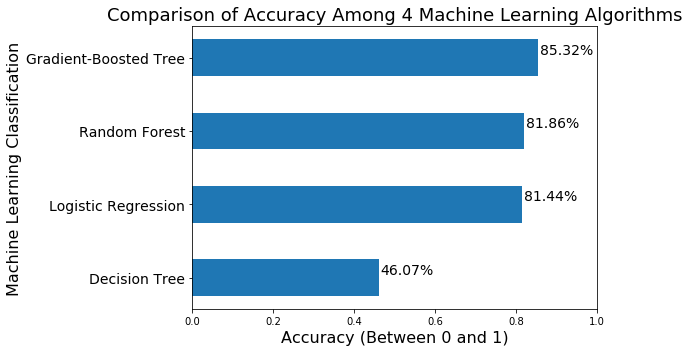

In [56]:
# plot
bar_width = 0.5
fig, ax = plt.subplots(figsize = (9,5))
plt.barh(y_pos, x_axis, bar_width, align='center', color='C0')
plt.yticks(y_pos, objects, fontsize=14)
plt.ylabel('Machine Learning Classification',fontsize=16)
plt.xlabel('Accuracy (Between 0 and 1)', fontsize=16)
plt.title('Comparison of Accuracy Among 4 Machine Learning Algorithms', fontsize=18)
plt.tight_layout()
for x, y in zip(x_axis, y_pos):
    label = str(round(x* 100,2)) + "%" 
    plt.text(x + 0.005, y+0.05, label, fontsize=14)
ax.set_xlim([0.0, 1.0])  
plt.show()

## Step09

## Calculate the confusion matrix and find the precision, recall, and F1 score of  each classification algorithm.

In [57]:
from pyspark.mllib.evaluation import MulticlassMetrics

def confusionMatrix(df, algorithm_name):
    result = df.select("labelIndex", "prediction")
    tp = result.filter((result["labelIndex"]==1.0) & (result["prediction"]==1.0)).count()
    fn = result.filter((result["labelIndex"]==1.0) & (result["prediction"]==0.0)).count()
    fp = result.filter((result["labelIndex"]==0.0) & (result["prediction"]==1.0)).count()
    precision = round(tp/(tp + fp),2)
    recall = round(tp/(tp + fn),2)
    f1 = 2 * (precision * recall)/(precision + recall)
    print("------------------------------------------------")
    print(algorithm_name, ":")
    print()
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("------------------------------------------------")

In [58]:
confusionMatrix(predictions_dt, "Decision Tree")
confusionMatrix(predictions_rf, "Random Forest")
confusionMatrix(predictions_lr, "Logistic Regression")
confusionMatrix(predictions_gbt, "Gradient-Boosted Tree")

------------------------------------------------
Decision Tree :

Precision:  0.74
Recall:  0.43
F1 Score:  0.543931623931624
------------------------------------------------
------------------------------------------------
Random Forest :

Precision:  0.79
Recall:  0.28
F1 Score:  0.41345794392523366
------------------------------------------------
------------------------------------------------
Logistic Regression :

Precision:  0.64
Recall:  0.42
F1 Score:  0.5071698113207547
------------------------------------------------
------------------------------------------------
Gradient-Boosted Tree :

Precision:  0.72
Recall:  0.47
F1 Score:  0.5687394957983193
------------------------------------------------


## Suggestions on improving the Accuracy of the Prediction

## 1. Reducing Unnecessary Features

Reducing the features while ensuring all training features are highly related would improve the accuracy of the Decision Tree and Random Forest algorithms.

In other words, instead of blindly increasing the feature to improve the model fitting, it would be better to
only select highly related features. The purpose is to reduce the noises and prediction bias. Scholar, Nasution, from  Universitas Pembangunan Panca Budi in Indonesia have proved the theory with the decision tree algorithm, while Researcher Nakagawa have proved the random forest algorithms. Both of them have achieved over 90% of accuracy by reducing the features. Lee has compared all 4 algorithms here with the same feature reduction strategy and all algorithm have improved 2% accuracy.

On implementing this suggestion, there are two possible apporaches. The first approach is to repeatedly reduce certain features and evaluate the prediction accuracy so as to select the important features. The second approach is to generalize the features such as grouping similar features into the "wind direction related" feature so that only the number of the features would reduce while teh coverage of the features would still be complete. The first approach was taken by Nasution in improving the Decision Tree, while Nakagawa have tried both approaches in the random forest and generated over 93% of accuracy.

## 2. Essemble multiple models to combine the strength of each model at a cost-effective way
Essembling different models have been proved to help improve the accuracy.

In our own practice, the random forest predicts almost double as accurate as the decision tree.

One of the University of A Coru˜na's Computer Science Lectures have clarified the power of essembling.
The purpose is to reduce the noise of the data.



## References:


"Ensemble of minimal learning machines for pattern classification"
Mesquita, D.P.P. ; Gomes, J.P.P. ; Junior, A.H.S. Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 2015, Vol.9095, Part II, pp.142-152

"PCA based feature reduction to improve the accuracy of decision tree c4.5 classification"
Nasution, M.Z.F. Sitompul, O.S. Ramli, M. Journal of Physics: Conference Series, 16 March 2018, Vol.978(1).Ser. 978 012058. 

"Predicting movie success with machine learning techniques: ways to improve accuracy"
Lee, Kyuhan ; Park, Jinsoo ; Kim, Iljoo ; Choi, Youngseok. Information Systems Frontiers, 2018, Vol.20(3), pp.577-588.

"Toward real-time in-home activity recognition using indoor positioning sensor and power meters"
Nakagawa, Eri. Moriya, Kazuki. Suwa, Hirohiko. Fujimoto, Manato. Arakawa, Yutaka. Yasumoto, Keiichi.
2017 IEEE International Conference on Pervasive Computing and Communications Workshops (PerCom Workshops), March 2017, pp.539-544.

### This is the End of the Assignment.